# Cleaning and Basic Feature Extraction

In this notebook we aim to do some basic cleaning of the data and extract musically informed features that are human understandable.

First we load in the various dependencies that will be used in this notebook.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4
import librosa
import librosa.display

import IPython.display
import scipy

Dataset explored is UrbanSound8K:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

https://urbansounddataset.weebly.com/urbansound8k.html

https://zenodo.org/record/1203745

First things first, we should load in the provided metadata and write a few convienience functions for getting the .wav files based on the provided metadata.

In [2]:
# Data should be placed in the "large_data/" directory, which is not staged in the git repo
metadata = pd.read_csv('./large_data/UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.info()
display(metadata)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [3]:
# Function to load wav file with librosa, given a row from metadata table
def load_data(meta_row):
    filename = meta_row['slice_file_name']
    filepath = f'large_data/UrbanSound8K/audio/fold{meta_row["fold"]}/'
    return librosa.load(filepath+filename,sr=None)

The various audiofiles do not exhibit a uniform length or sampling rate. As such we aim to do some pre-classification analysis to generate a uniform observable vector.

For this reason we are going to take inspiration from the idea of a music "equalizer" scale. We will break down the fourier transform of each audio section into a number of human audible frequencies, as well as the sub-audible and supra-audible sections.

<img src="FrequencySpectrumDivision-1.jpeg" width="600" height="300">

Image source: https://blog.landr.com/sound-frequency-eq/

Get a sound and load it in.

In [472]:
# # Siren
# row_ind = metadata.loc[514]
# test_y, sr = load_data(row_ind)

# # music
row_ind = metadata.loc[97]
test_y, sr = load_data(row_ind)

# # car horn
# row_ind = metadata.loc[13]
# test_y, sr = load_data(row_ind)

## chilren
# row_ind = metadata.loc[3]
# test_y, sr = load_data(row_ind)

## jackhammer
# row_ind = metadata.loc[173]
# test_y, sr = load_data(row_ind)

## gun shot
# row_ind = metadata.loc[106]
# test_y, sr = load_data(row_ind)

In [473]:
row_ind

slice_file_name    101848-9-0-3.wav
fsID                         101848
start                           1.5
end                             5.5
salience                          1
fold                              7
classID                           9
class                  street_music
Name: 97, dtype: object

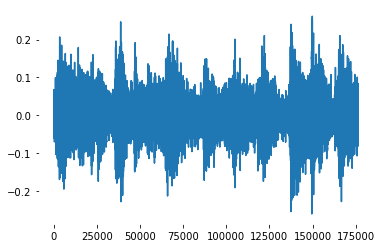

In [474]:
plt.plot(test_y)
IPython.display.Audio(test_y / test_y.max(),rate=sr)

From this we need to extract the total length of the file, and the time per index in order to properly bin the fourier spectrum of the audio signal.

In [475]:
len(test_y)

t = round(row_ind["end"]-row_ind["start"],3)
dt = t/len(test_y)
print(dt)

k = np.fft.fftfreq(len(test_y), d=dt)
print(k[1])

yk = np.fft.fft(test_y)
mag_yk = np.abs(yk)
mag_yk = mag_yk[:len(mag_yk)//2]

2.2675736961451248e-05
0.25


I will also extract the crest factor as this may be a nice measurement of the "suddenness" of a sound. Crest factor, sometime also referred to as peak-to-average power ratio is defined as
\begin{equation}
Cr = \frac{max(amplitude)}{rms(amplitude)}\,.
\end{equation}

In [476]:
test_y2 = np.sqrt(test_y*test_y)
yk2 = np.fft.fft(test_y2)
mag_yk2 = np.abs(yk2)
mag_yk2 = mag_yk2[:len(mag_yk2)//2]

test_y.max()

np.sqrt(test_y2.mean())

Crestfactor = test_y.max()/np.sqrt(test_y2.mean())
Crestfactor

1.3372778

After initial exploration of the data I noticed that a number of the audio samples have significant "room noise" present. In an attempt to clean this up I'm taking the absolute value of the hilbert transform, as this extracts the instantaneous amplitude of a signal. Smoothing this transform and dividing by the root mean square power should then amplify the parts of the signal that are large in amplitude, while minimizing the areas that are simply a constant amplitude "hum". Low crest factor systems will be largely unaffected as the amplitude will be similar to the root mean square of the signal for such signals. Finally we ensure that the maximum amplitude of the signal is scaled to be equal to the input signal.

In [477]:
# unfiltered hilbert scaling
testwav = test_y * np.abs(np.abs(scipy.signal.hilbert(test_y)))/np.sqrt((test_y*test_y).mean())
testwav *= test_y.max() / testwav.max()

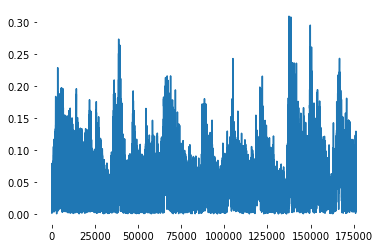

In [478]:
hil = np.abs(scipy.signal.hilbert(test_y))
plt.plot(hil)

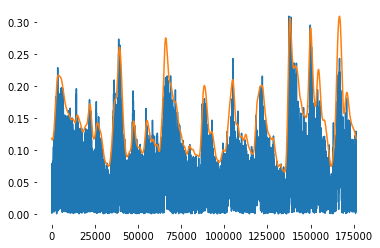

In [479]:
# filter the hilbert transform and make sure things look okay
hilk = np.fft.fft(hil)
hilk *= np.exp(-k*k / (2*10**2))
hil2 = np.fft.ifft(hilk)
hil2 = np.abs(hil2)
hil2 *= hil.max() / hil2.max()
plt.plot(hil)
plt.plot(np.abs(hil2))

In [480]:
# filtered hilbert scaling
testwav2 = test_y * hil2/np.sqrt((test_y*test_y).mean())
testwav2 *= test_y.max() / testwav2.max()

(-8819.95, 185218.95, -0.28858489866368814, 0.33738248131245047)

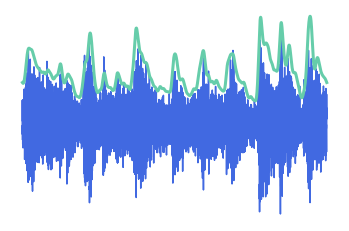

In [481]:
plt.plot(test_y,color='royalblue')
plt.plot(np.abs(hil2),color='mediumaquamarine',linewidth=3)
plt.axis('off')

(-8819.95, 185218.95, -0.27197313366117154, 0.2870207514355022)

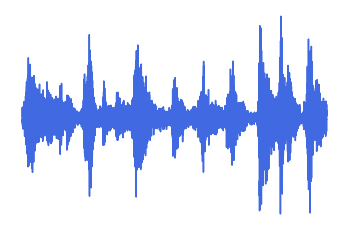

In [482]:
plt.plot(testwav2,color='royalblue')
# plt.plot(np.abs(hil2))
plt.axis('off')

In [455]:
sf.write('./filtered_music.wav', testwav2/testwav2.max(), sr)

In [341]:
import soundfile as sf

To ensure that our cleaning here hasn't been catastrophic we listen to the audio files. Without filtering of the hilbert transform there is noticable distortion in the signal.

In [342]:
# Unadulterated audio signal
IPython.display.Audio(test_y / test_y.max(),rate=sr)

In [343]:
# Scaling by unfiltered hilbert transform
IPython.display.Audio(testwav / testwav.max() * test_y.max(),rate=sr)

In [344]:
# Scaling by filtered hilbert tranform
IPython.display.Audio(testwav2 / testwav2.max() * test_y.max(),rate=sr)

We now generate the equilizer values by manually summing over the relevent portions of fourier space. Here we do this with each of the 3 signals to see how our cleaning step is affecting the results

In [483]:
# eq_cutoffs = [20.0, 40.0, 80.0, 160.0, 300.0, 600.0, 1200.0, 2400.0, 5000.0, 10000.0, 20000.0, np.inf]
eq_cutoffs = [10.0, 20.0, 30.0, 40.0, 60.0, 80.0, 120.0, 160.0, 230.0, 300.0, 450.0, 600.0, 900.0, 1200.0, 1800.0, 2400.0, 3700.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0, np.inf]


equilizer = np.zeros(len(eq_cutoffs))
equilizer2 = np.zeros(len(eq_cutoffs))
equilizer3 = np.zeros(len(eq_cutoffs))

ykclean = np.fft.fft(testwav)
mag_ykclean = np.abs(ykclean)
mag_ykclean = mag_ykclean[:len(mag_ykclean)//2]

ykclean2 = np.fft.fft(testwav2)
mag_ykclean2 = np.abs(ykclean2)
mag_ykclean2 = mag_ykclean2[:len(mag_ykclean2)//2]

index = 0
for i in range(len(eq_cutoffs)):
    num = 0
    while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
        equilizer[i] += mag_yk[index]
        equilizer2[i] += mag_ykclean[index]
        equilizer3[i] += mag_ykclean2[index]
        index += 1
        num += 1

    equilizer[i] /= num
    equilizer2[i] /= num
    equilizer3[i] /= num
    
equilizer /= equilizer.max()
equilizer2 /= equilizer2.max()
equilizer3 /= equilizer3.max()

In [484]:
print(equilizer)
print(equilizer2)
print(equilizer3)

[0.0202122  0.05358632 0.12788455 0.18879877 0.17772676 0.60558289
 0.96346202 0.62720398 1.         0.51595211 0.37829016 0.31582882
 0.17078366 0.17878827 0.10339017 0.07347269 0.03256725 0.01969288
 0.01647588 0.00758346 0.00726851 0.00219206 0.00134692]
[0.17049551 0.13042016 0.17777446 0.19897812 0.19012314 0.55234352
 0.78259524 0.57458872 1.         0.50577947 0.34768275 0.27692088
 0.16870985 0.17034548 0.10641639 0.0783571  0.03656239 0.02319063
 0.01797397 0.00796626 0.00781643 0.00229722 0.00135158]
[1.43562780e-02 3.62081630e-02 8.81912212e-02 1.41322401e-01
 1.26656217e-01 4.74942157e-01 7.80395795e-01 5.13221627e-01
 1.00000000e+00 4.40100359e-01 2.90611465e-01 2.35216870e-01
 1.27575754e-01 1.35273258e-01 7.99776089e-02 5.83214728e-02
 2.56429343e-02 1.45028587e-02 1.25375044e-02 5.73634313e-03
 5.58882841e-03 1.62095606e-03 9.48343617e-04]


Sanity check with some plots. We notice that the unfiltered version of our clean up step displays distortion in the numerical data as well as testing by ear.

(-1.54, 23.540000000000003, 0.0, 1.05)

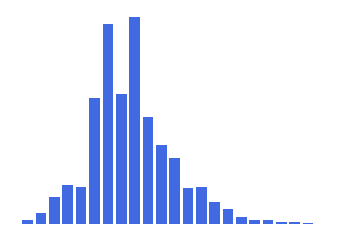

In [485]:
# plt.bar(range(len(eq_cutoffs)),equilizer)
# plt.bar(range(len(eq_cutoffs)),equilizer2)


Hzranges = ['0-10Hz', '10-20Hz', '20-30Hz', '30-40Hz', '40-60Hz', '60-80Hz', '80-120Hz', '120-160Hz', '160-230Hz', '230-300Hz', '300-450Hz', '450-600Hz', '600-900Hz', '0.9-1.2kHz', '1.2-1.8kHz', '1.8-2.4kHz', '2.4-3.7kHz', '3.7-5kHz','5-7.5kHz','7.5-10kHz','10-15kHz','15-20kHz','>20kHz']
# fig, ax = plt.subplots()
# side = ax.spines["right"]
# side.set_visible(False)
# side = ax.spines["left"]
# side.set_visible(False)
# side = ax.spines["top"]
# side.set_visible(False)
plt.bar(Hzranges,equilizer,color='royalblue')
# plt.yticks(range(1)," ")
# plt.xticks(rotation='vertical')
plt.axis('off')

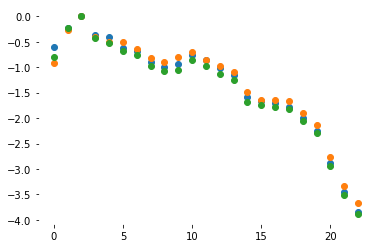

In [468]:
plt.scatter(range(len(eq_cutoffs)),np.log(equilizer)/np.log(10.0))
plt.scatter(range(len(eq_cutoffs)),np.log(equilizer2)/np.log(10.0))
plt.scatter(range(len(eq_cutoffs)),np.log(equilizer3)/np.log(10.0))

We have been iterating through feature selection, and fitting, and examination of the confusion matrix shows that
1. The classifier stuggles to differentiate between music and other types of data.
2. Gun shots and children playing are often paired in the confusion matrix.

We expect that children playing should be a much more "musical" type of sound than gun shots. For these two reasons we are going to try and extract some music based features.

Librosa has a function to decompose the harmonic and percussive components of a spectrogram. This seems to be done by checking for peaks in the fourier domain (harmonic) and time domain (percussive).

In [456]:
D = librosa.stft(testwav2 / testwav2.max())
y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)

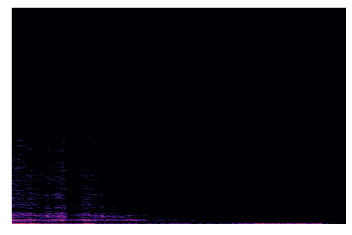

In [457]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(y_harmonic),ref=np.max))

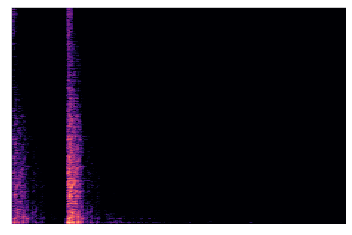

In [458]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(y_percussive),ref=np.max))

The decomposition loses a certain amount of power based on the 'margin' command which essentially sets how harsh the decomposition should be. For this reason we are going to rescale the power such that the sum of the two components still holds the same level of total power.

0.9999999999999999 0.8841165049763627 0.11588349502363711 0.9999999999999999


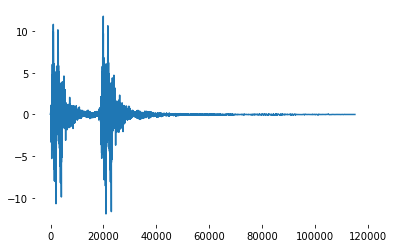

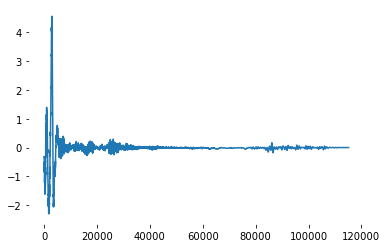

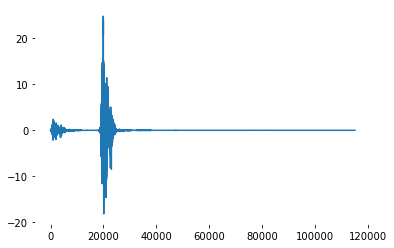

<Figure size 432x288 with 0 Axes>

In [459]:
D = librosa.stft(testwav2 / testwav2.max())
y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)
y_p = librosa.istft(y_percussive, length=len(testwav2))
y_h = librosa.istft(y_harmonic, length=len(testwav2))
Ptot = (testwav2**2).mean()
ynorm = testwav2 / np.sqrt(Ptot)
Pnorm = (ynorm**2).mean()
P_p = (y_p**2).mean()
P_h = (y_h**2).mean()
Anorm = np.sqrt(Pnorm/(P_h+P_p))
y_p *= Anorm
y_h *= Anorm
P_p = (y_p**2).mean()
P_h = (y_h**2).mean()

print(Pnorm, P_p, P_h, (P_h + P_p))
plt.figure()
plt.plot(ynorm)
plt.figure()
plt.plot(y_h)
plt.figure()
plt.plot(y_p)
plt.figure()

y_percussive = librosa.stft(y_p)
y_harmonic = librosa.stft(y_h)

From the harmonic component we are going to generate a measure of the harmonics within the sound wave. A great deal of music is made up of chords from major thirds, minor thirds, major fifths, and a triplet consisting of a base frequency with its major third and major fifth.

The first thing we are going to do is extract the mean power in the various frequencies corresponding to different MIDI keys. A major third is then a pair consisting of a base frequency (MIDI $n$) and the key whose central frequency is closest to $3 f_n /2$. In a MIDI keyboard this then is the pair (MIDI $n$)+(MIDI $n+4$). Similarly minor thirds are (MIDI $n$)+(MIDI $n+3$), and major fifths are (MIDI $n$)+(MIDI $n+7$).

In [420]:
print(y_harmonic.shape, t, 0.1565*len(testwav2))

(1025, 345) 4.0 27606.6


(-8819.95, 185218.95, -0.27197313366117154, 0.2870207514355022)

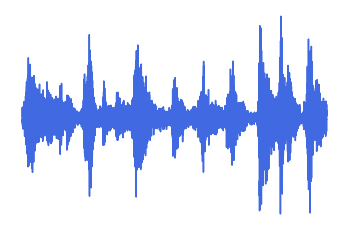

In [439]:
plt.plot(testwav2,color='royalblue')
# plt.plot(np.abs(hil2))
plt.axis('off')
# plt.axvline(x=28121.688000000002,color='mediumaquamarine')
# plt.axvline(x=27606.6,color='mediumaquamarine')

(-8819.95, 185218.95, -17.676592340169258, 13.1506114771178)

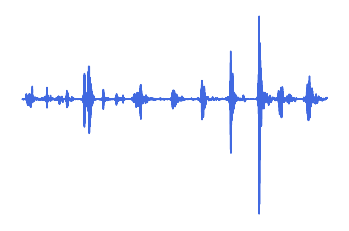

In [441]:
plt.plot(y_p,color='royalblue')
plt.axis('off')

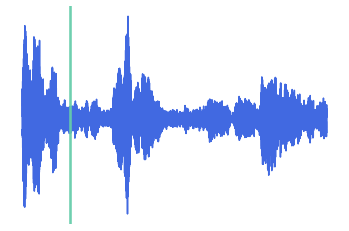

In [443]:
plt.plot(y_h,color='royalblue')
plt.axis('off')
plt.axvline(x=28121.688000000002,color='mediumaquamarine')
plt.axvline(x=27606.6,color='mediumaquamarine')

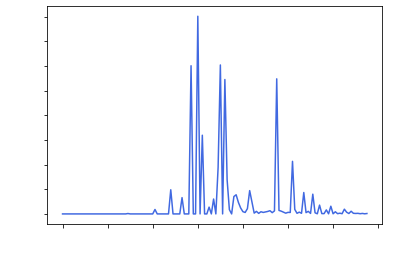

In [428]:
plt.figure()
plt.plot(midi, fbins,color='royalblue')
plt.ylabel("Interval Power",color='white')
plt.xlabel("Interval Fundamental (MIDI number)",color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.rc('axes',edgecolor='white')

67


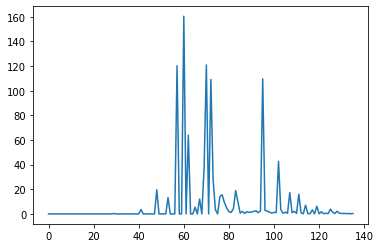

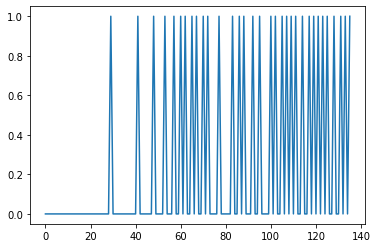

In [381]:
st_k = np.fft.fftfreq(np.size(y_harmonic,0), d=dt)
fbins = []
keypitch = []
midi = []
maxlen=np.size(y_harmonic,0)
tm = 54
p = -69
kmin = 440*2**((p - 0.5)/12)
kmax = 440*2**((p+0.5)/12)
while kmax <= 20000:
    kmin = 440*2**((p - 0.5)/12)
    kmax = 440*2**((p+0.5)/12)
    if (len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm])) != 0) :
        sumbin = np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]).sum() / len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]))
    else:
        sumbin = 0
    fbins.append(sumbin)
    keypitch.append(440*2**(p/12))
    midi.append(p+69)
    p += 1
print(p)
plt.figure()
plt.plot(midi, fbins)
len(librosa.util.peak_pick(np.asarray(fbins), pre_max=1, post_max=1, pre_avg=1, post_avg=1, delta=0, wait=0))
peaks = librosa.util.localmax(np.asarray(fbins))
plt.figure()
plt.plot(np.asarray(peaks))

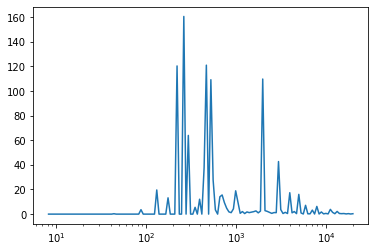

In [387]:
plt.semilogx(keypitch, fbins)

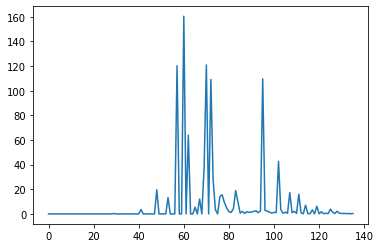

In [384]:
plt.plot(midi, fbins)

there are  1  major third(s),  4  minor third(s),  6  major third(s), and  2  major chord(s).


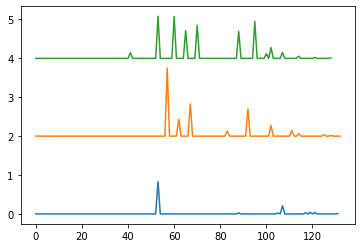

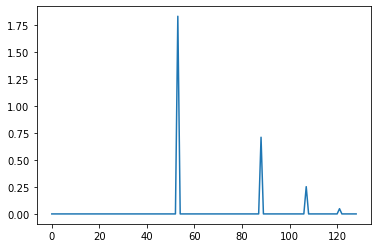

In [395]:
maj3 = []
min3 = []
maj5 = []
majchord = []
fbins = np.asarray(fbins)
favg = fbins[fbins > 0].max()
for i in range(len(fbins)-4):
    maj3.append(peaks[i]*peaks[i+4]*(fbins[i] + fbins[i+4])/favg)
for i in range(len(fbins)-3):
    min3.append(peaks[i]*peaks[i+3]*(fbins[i] + fbins[i+3])/favg)
for i in range(len(fbins)-7):
    maj5.append(peaks[i]*peaks[i+7]*(fbins[i] + fbins[i+7])/favg)
    majchord.append(peaks[i]*peaks[i+4]*peaks[i+7]*(fbins[i] + fbins[i+4] + fbins[i+7])/favg)


maj3 = np.asarray(maj3)
min3 = np.asarray(min3)
maj5 = np.asarray(maj5)
majchord = np.asarray(majchord)
harmonicality  = len(maj3[np.log10(maj3+1e-12)>=-0.5]) + len(min3[np.log10(min3+1e-12)>=-0.5])+len(maj5[np.log10(maj5+1e-12)>=-0.5])+len(majchord[np.log10(majchord+1e-12)>=-0.5])
print("there are ",len(maj3[np.log10(maj3+1e-12)>=-0.5])," major third(s), ",
      len(min3[np.log10(min3+1e-12)>=-0.5])," minor third(s), ",
      len(maj5[np.log10(maj5+1e-12)>=-0.5])," major third(s), and ",
      len(majchord[np.log10(majchord+1e-12)>=-0.5])," major chord(s).")

plt.figure()
plt.plot((2*np.asarray(maj3)/np.asarray(maj3).max() +1e-9))
# plt.figure()
plt.plot((2*np.asarray(min3)/np.asarray(min3).max() +1e-9 + 2))
# plt.figure()
plt.plot((2*np.asarray(maj5)/np.asarray(maj5).max +1e-9 + 4))
plt.figure()
plt.plot((np.asarray(majchord) +1e-9))

Text(0.5, 0, 'Interval Fundamental (MIDI number)')

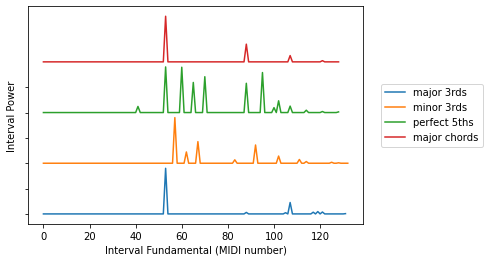

In [415]:
plt.figure()
plt.plot((1.8*np.asarray(maj3)/np.asarray(maj3).max() +1e-9))
# plt.figure()
plt.plot((1.8*np.asarray(min3)/np.asarray(min3).max() +1e-9 + 2))
# plt.figure()
plt.plot((1.8*np.asarray(maj5)/np.asarray(maj5).max() +1e-9 + 4))
plt.plot(1.8*np.asarray(majchord)/np.asarray(majchord).max() +1e-9 + 6)
plt.legend(['major 3rds', 'minor 3rds', 'perfect 5ths', 'major chords'],bbox_to_anchor=(1.04,0.5), loc="center left")
plt.yticks(range(6), "")
plt.ylabel("Interval Power")
plt.xlabel("Interval Fundamental (MIDI number)")

We also want to recognize the percussive hits. This is easy enough to do using the librosa onset_strength function. We then use peak detection to generate the total number of percussive crashes in the soundwave.

percussive peaks are at  [ 3 38] for a total length of  2


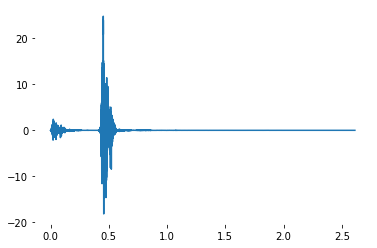

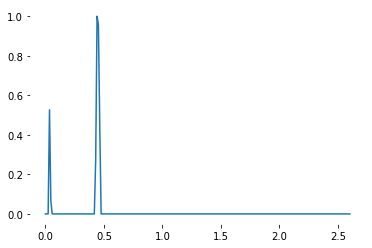

In [460]:
y_out = librosa.istft(y_percussive, length=len(test_y))
times = librosa.times_like(y_percussive)
plt.plot(dt*range(len(y_out)),y_out)
onset_env = librosa.onset.onset_strength(y=y_out, sr=sr,
#                                           hop_length=512,
                                         max_size=5,
                                          aggregate=np.median)
plt.figure()
plt.plot(times/2, onset_env / onset_env.max())
perc_peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=0)
# onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
# onset_frames = librosa.onset.onset_detect(y = y_out, sr=sr)

print("percussive peaks are at ", perc_peaks, "for a total length of ", len(perc_peaks))

(-0.13059886534434975,
 2.742576172231345,
 -0.8195473198997661,
 1.0866451104714174)

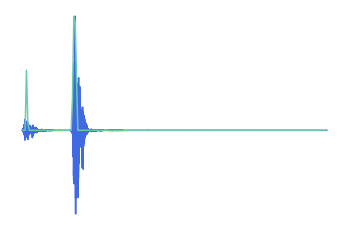

In [461]:
# plt.plot(dt*range(len(testwav2)),testwav2/testwav2.max(),color='royalblue')
plt.plot(dt*range(len(y_out)),y_out/y_out.max(),color='royalblue')
plt.plot(times/2, onset_env / onset_env.max(), color='mediumaquamarine')
plt.axis('off')

Make a function to do the cleanup and save the results as a nice, compact csv file.

We have iterated on the features a number of times, as can be seen by the commented out headers. In this version we include salience (whether the sound is background or foreground), as well as the power in the percussive and harmonic parts, and the number of percussive hits, and the time averaged number of harmonic chords.

Salience is ultimately removed in the classification notebooks, but there is little reason to regenerate the csv files.

In [36]:
def make_csv(filenm):
    file = open(filenm,'w+')
#     file.write("class,eq_0,eq_20,eq_40,eq_80,eq_160,eq_300,eq_600,eq_1200,eq_2400,eq_5000,eq_10000,eq_20000,crestfactor,fold\n")
#     file.write("class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,thirds,fifths,fold\n")
#     file.write("class,eq_0,eq_20,eq_40,eq_80,eq_160,eq_300,eq_600,eq_1200,eq_2400,eq_5000,eq_10000,eq_20000,crestfactor,musicality,fold\n")
    file.write("class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold\n")


#     eq_cutoffs = [20.0, 40.0, 80.0, 160.0, 300.0, 600.0, 1200.0, 2400.0, 5000.0, 10000.0, 20000.0, np.inf]
    eq_cutoffs = [10.0, 20.0, 30.0, 40.0, 60.0, 80.0, 120.0, 160.0, 230.0, 300.0, 450.0, 600.0, 900.0, 1200.0, 1800.0, 2400.0, 3700.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0, np.inf]


    for row_ind in range(0,len(metadata)):
        ## load in the data
        row = metadata.loc[row_ind]
        y,sr = load_data(metadata.loc[row_ind])
        ## get the class and fold
        classifier = metadata['class'][row_ind]
        foldinfo = metadata['fold'][row_ind]
        ## get timing info
        t = round(row["end"]-row["start"],3)
        dt = t/len(y)
        k = np.fft.fftfreq(len(y), d=dt)
#         k = k[:len(k)//2]
        ## get salience
        sal = row["salience"]
        
        
        ## hilbert transform filtering for "room noise"
        hil = np.abs(scipy.signal.hilbert(y))
        hilk = np.fft.fft(hil)
        hilk *= np.exp(-k*k / (2*10**2))
        hil2 = np.fft.ifft(hilk)
        hil2 = np.abs(hil2)
        hil2 *= hil.max() / hil2.max()
        filt_y = y * hil2/np.sqrt((y*y).mean())
        filt_y *= y.max() / filt_y.max()
        y_sq = filt_y*filt_y
        ## get crest factor
        Cr = filt_y.max() / np.sqrt(y_sq.mean())
        
        yk = np.fft.fft(filt_y)
        mag_yk = np.abs(yk)
        mag_yk = mag_yk[:len(mag_yk)//2]
        
        ## seperate into harmonic and percussive components
        D = librosa.stft(filt_y / filt_y.max())
        y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)
        y_p = librosa.istft(y_percussive, length=len(filt_y))
        y_h = librosa.istft(y_harmonic, length=len(filt_y))
        Ptot = (filt_y**2).mean()
        ynorm = filt_y / np.sqrt(Ptot)
        Pnorm = (ynorm**2).mean()
        P_p = (y_p**2).mean()
        P_h = (y_h**2).mean()
        Anorm = np.sqrt(Pnorm/(P_h+P_p))
        y_p *= Anorm
        y_h *= Anorm
        
        y_percussive = librosa.stft(y_p)
        y_harmonic = librosa.stft(y_h)
        
        ## generate the MIDI range and corresponding frequencies
        st_k = np.fft.fftfreq(np.size(y_harmonic,0), d=dt)
        fbins = []
        keypitch = []
        midi = []
        maxlen=np.size(y_harmonic,0)
        p = -69
        kmin = 440*2**((p - 0.5)/12)
        kmax = 440*2**((p+0.5)/12)
        while kmax <= 20000:
            kmin = 440*2**((p - 0.5)/12)
            kmax = 440*2**((p+0.5)/12)
            keypitch.append(440*2**(p/12))
            midi.append(p+69)
            p += 1
            
        ## sum up the number of 3rds, 5ths, and chords
        harmonicality = 0
        for tm in range(np.size(y_harmonic,1)):
            p = -69
            kmin = 440*2**((p - 0.5)/12)
            kmax = 440*2**((p+0.5)/12)    
            while kmax <= 20000:
                kmin = 440*2**((p - 0.5)/12)
                kmax = 440*2**((p+0.5)/12)
                if (len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm])) != 0) :
                    sumbin = np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]).sum() / len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]))
                else:
                    sumbin = 0
                fbins.append(sumbin)
                p += 1

            peaks = librosa.util.localmax(np.asarray(fbins))

            maj3 = []
            min3 = []
            maj5 = []
            majchord = []
            fbins2 = np.asarray(fbins)
            if len(fbins2[fbins2 > 0] > 0):
                favg = fbins2[fbins2 > 0].max()
            else:
                favg = 1
            for i in range(len(fbins)-4):
                maj3.append(peaks[i]*peaks[i+4]*(fbins[i] + fbins[i+4])/favg)
            for i in range(len(fbins)-3):
                min3.append(peaks[i]*peaks[i+3]*(fbins[i] + fbins[i+3])/favg)
            for i in range(len(fbins)-7):
                maj5.append(peaks[i]*peaks[i+7]*(fbins[i] + fbins[i+7])/favg)
                majchord.append(peaks[i]*peaks[i+4]*peaks[i+7]*(fbins[i] + fbins[i+4] + fbins[i+7])/favg)


            maj3 = np.asarray(maj3)
            min3 = np.asarray(min3)
            maj5 = np.asarray(maj5)
            majchord = np.asarray(majchord)
            maj3 = len(maj3[np.log10(maj3 + 1e-12)>=-0.5])
            min3 = len(min3[np.log10(min3 + 1e-12)>=-0.5])
            maj5 = len(maj5[np.log10(maj5 + 1e-12)>=-0.5])
            majchord = len(majchord[np.log10(majchord + 1e-12)>=-0.5])
            harmonicality += maj3 + min3 + maj5 + majchord
        
        ## divide by the number of time slices to get mean harmonicality
        harmrate = harmonicality / np.size(y_harmonic,1)
        
        
        ## from the percussive component get the onsets for number of percussive hits
        y_out = librosa.istft(y_percussive, length=len(filt_y))

        onset_env = librosa.onset.onset_strength(y=y_out, sr=sr,
                                                 max_size=5,
                                                  aggregate=np.median)

        perc_peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=0)


        perc_rate = len(perc_peaks) #/ t
        
        ## generate equilizer values from fourier transform
        equilizer = np.zeros(len(eq_cutoffs))
        for i in range(len(equilizer)):
            index = 0
            num = 0
            while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
                equilizer[i] += mag_yk[index]
                index += 1
                num += 1
            equilizer[i] /= num
            
        ## write everything to csv
        file.write(classifier)
        for i in range(len(eq_cutoffs)):
            file.write(","+str(equilizer[i]))
        
        file.write(","+str(Cr))
        file.write(","+str(sal))
        file.write(","+str(P_h))
        file.write(","+str(P_p))
        file.write(","+str(harmrate))
        file.write(","+str(perc_rate))
        file.write(","+str(foldinfo)+"\n")
        print("preprocessed audio file ", str(row_ind))
    file.close()

In [470]:
def make_eq_only_csv(filenm):
    file = open(filenm,'w+')
#     file.write("class,eq_0,eq_20,eq_40,eq_80,eq_160,eq_300,eq_600,eq_1200,eq_2400,eq_5000,eq_10000,eq_20000,crestfactor,fold\n")
#     file.write("class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,thirds,fifths,fold\n")
#     file.write("class,eq_0,eq_20,eq_40,eq_80,eq_160,eq_300,eq_600,eq_1200,eq_2400,eq_5000,eq_10000,eq_20000,crestfactor,musicality,fold\n")
    file.write("class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold\n")


#     eq_cutoffs = [20.0, 40.0, 80.0, 160.0, 300.0, 600.0, 1200.0, 2400.0, 5000.0, 10000.0, 20000.0, np.inf]
    eq_cutoffs = [10.0, 20.0, 30.0, 40.0, 60.0, 80.0, 120.0, 160.0, 230.0, 300.0, 450.0, 600.0, 900.0, 1200.0, 1800.0, 2400.0, 3700.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0, np.inf]


    for row_ind in range(0,len(metadata)):
        ## load in the data
        row = metadata.loc[row_ind]
        y,sr = load_data(metadata.loc[row_ind])
        ## get the class and fold
        classifier = metadata['class'][row_ind]
        foldinfo = metadata['fold'][row_ind]
        ## get timing info
        t = round(row["end"]-row["start"],3)
        dt = t/len(y)
        k = np.fft.fftfreq(len(y), d=dt)
#         k = k[:len(k)//2]
        ## get salience
        sal = row["salience"]
        
        
        ## hilbert transform filtering for "room noise"
        hil = np.abs(scipy.signal.hilbert(y))
        hilk = np.fft.fft(hil)
        hilk *= np.exp(-k*k / (2*10**2))
        hil2 = np.fft.ifft(hilk)
        hil2 = np.abs(hil2)
        hil2 *= hil.max() / hil2.max()
        filt_y = y * hil2/np.sqrt((y*y).mean())
        filt_y *= y.max() / filt_y.max()
        y_sq = filt_y*filt_y
        ## get crest factor
        Cr = filt_y.max() / np.sqrt(y_sq.mean())
        
        yk = np.fft.fft(filt_y)
        mag_yk = np.abs(yk)
        mag_yk = mag_yk[:len(mag_yk)//2]
        
        ## generate equilizer values from fourier transform
        index = 0
        equilizer = np.zeros(len(eq_cutoffs))
        for i in range(len(equilizer)):
            num = 0
            while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
                equilizer[i] += mag_yk[index]
                index += 1
                num += 1
            equilizer[i] /= num
            
        ## write everything to csv
        file.write(str(row_ind)+",")
        file.write(classifier)
        for i in range(len(eq_cutoffs)):
            file.write(","+str(equilizer[i]))
        
        file.write(","+str(Cr))
        file.write(","+str(sal))
        file.write(","+str(foldinfo)+"\n")
        print("preprocessed audio file ", str(row_ind))
    file.close()

This preprocessing takes a rather long period of time. For this reason, we choose not to run it locally within the jupyter notebook, but to delegate it to a small workstation of 20 dual threaded processors, parallelized using the jobslib library in python.

In [471]:
make_eq_only_csv('./large_data/eq_only_corrected.csv')

preprocessed audio file  0
preprocessed audio file  1
preprocessed audio file  2
preprocessed audio file  3
preprocessed audio file  4
preprocessed audio file  5
preprocessed audio file  6
preprocessed audio file  7
preprocessed audio file  8
preprocessed audio file  9
preprocessed audio file  10
preprocessed audio file  11
preprocessed audio file  12
preprocessed audio file  13
preprocessed audio file  14
preprocessed audio file  15
preprocessed audio file  16
preprocessed audio file  17
preprocessed audio file  18
preprocessed audio file  19
preprocessed audio file  20
preprocessed audio file  21
preprocessed audio file  22
preprocessed audio file  23
preprocessed audio file  24
preprocessed audio file  25
preprocessed audio file  26
preprocessed audio file  27
preprocessed audio file  28
preprocessed audio file  29
preprocessed audio file  30
preprocessed audio file  31
preprocessed audio file  32
preprocessed audio file  33
preprocessed audio file  34
preprocessed audio file  35
pr

preprocessed audio file  287
preprocessed audio file  288
preprocessed audio file  289
preprocessed audio file  290
preprocessed audio file  291
preprocessed audio file  292
preprocessed audio file  293
preprocessed audio file  294
preprocessed audio file  295
preprocessed audio file  296
preprocessed audio file  297
preprocessed audio file  298
preprocessed audio file  299
preprocessed audio file  300
preprocessed audio file  301
preprocessed audio file  302
preprocessed audio file  303
preprocessed audio file  304
preprocessed audio file  305
preprocessed audio file  306
preprocessed audio file  307
preprocessed audio file  308
preprocessed audio file  309
preprocessed audio file  310
preprocessed audio file  311
preprocessed audio file  312
preprocessed audio file  313
preprocessed audio file  314
preprocessed audio file  315
preprocessed audio file  316
preprocessed audio file  317
preprocessed audio file  318
preprocessed audio file  319
preprocessed audio file  320
preprocessed a

/var/folders/8b/9_w7wgkn0ksgvwhvvpcqjx2c0000gn/T/ipykernel_8754/3970213005.py:55: RuntimeWarning: invalid value encountered in double_scalars
  equilizer[i] /= num


preprocessed audio file  552
preprocessed audio file  553
preprocessed audio file  554
preprocessed audio file  555
preprocessed audio file  556
preprocessed audio file  557
preprocessed audio file  558
preprocessed audio file  559
preprocessed audio file  560
preprocessed audio file  561
preprocessed audio file  562
preprocessed audio file  563
preprocessed audio file  564
preprocessed audio file  565
preprocessed audio file  566
preprocessed audio file  567
preprocessed audio file  568
preprocessed audio file  569
preprocessed audio file  570
preprocessed audio file  571
preprocessed audio file  572
preprocessed audio file  573
preprocessed audio file  574
preprocessed audio file  575
preprocessed audio file  576
preprocessed audio file  577
preprocessed audio file  578
preprocessed audio file  579
preprocessed audio file  580
preprocessed audio file  581
preprocessed audio file  582
preprocessed audio file  583
preprocessed audio file  584
preprocessed audio file  585
preprocessed a

preprocessed audio file  835
preprocessed audio file  836
preprocessed audio file  837
preprocessed audio file  838
preprocessed audio file  839
preprocessed audio file  840
preprocessed audio file  841
preprocessed audio file  842
preprocessed audio file  843
preprocessed audio file  844
preprocessed audio file  845
preprocessed audio file  846
preprocessed audio file  847
preprocessed audio file  848
preprocessed audio file  849
preprocessed audio file  850
preprocessed audio file  851
preprocessed audio file  852
preprocessed audio file  853
preprocessed audio file  854
preprocessed audio file  855
preprocessed audio file  856
preprocessed audio file  857
preprocessed audio file  858
preprocessed audio file  859
preprocessed audio file  860
preprocessed audio file  861
preprocessed audio file  862
preprocessed audio file  863
preprocessed audio file  864
preprocessed audio file  865
preprocessed audio file  866
preprocessed audio file  867
preprocessed audio file  868
preprocessed a

preprocessed audio file  1114
preprocessed audio file  1115
preprocessed audio file  1116
preprocessed audio file  1117
preprocessed audio file  1118
preprocessed audio file  1119
preprocessed audio file  1120
preprocessed audio file  1121
preprocessed audio file  1122
preprocessed audio file  1123
preprocessed audio file  1124
preprocessed audio file  1125
preprocessed audio file  1126
preprocessed audio file  1127
preprocessed audio file  1128
preprocessed audio file  1129
preprocessed audio file  1130
preprocessed audio file  1131
preprocessed audio file  1132
preprocessed audio file  1133
preprocessed audio file  1134
preprocessed audio file  1135
preprocessed audio file  1136
preprocessed audio file  1137
preprocessed audio file  1138
preprocessed audio file  1139
preprocessed audio file  1140
preprocessed audio file  1141
preprocessed audio file  1142
preprocessed audio file  1143
preprocessed audio file  1144
preprocessed audio file  1145
preprocessed audio file  1146
preprocess

preprocessed audio file  1388
preprocessed audio file  1389
preprocessed audio file  1390
preprocessed audio file  1391
preprocessed audio file  1392
preprocessed audio file  1393
preprocessed audio file  1394
preprocessed audio file  1395
preprocessed audio file  1396
preprocessed audio file  1397
preprocessed audio file  1398
preprocessed audio file  1399
preprocessed audio file  1400
preprocessed audio file  1401
preprocessed audio file  1402
preprocessed audio file  1403
preprocessed audio file  1404
preprocessed audio file  1405
preprocessed audio file  1406
preprocessed audio file  1407
preprocessed audio file  1408
preprocessed audio file  1409
preprocessed audio file  1410
preprocessed audio file  1411
preprocessed audio file  1412
preprocessed audio file  1413
preprocessed audio file  1414
preprocessed audio file  1415
preprocessed audio file  1416
preprocessed audio file  1417
preprocessed audio file  1418
preprocessed audio file  1419
preprocessed audio file  1420
preprocess

preprocessed audio file  1662
preprocessed audio file  1663
preprocessed audio file  1664
preprocessed audio file  1665
preprocessed audio file  1666
preprocessed audio file  1667
preprocessed audio file  1668
preprocessed audio file  1669
preprocessed audio file  1670
preprocessed audio file  1671
preprocessed audio file  1672
preprocessed audio file  1673
preprocessed audio file  1674
preprocessed audio file  1675
preprocessed audio file  1676
preprocessed audio file  1677
preprocessed audio file  1678
preprocessed audio file  1679
preprocessed audio file  1680
preprocessed audio file  1681
preprocessed audio file  1682
preprocessed audio file  1683
preprocessed audio file  1684
preprocessed audio file  1685
preprocessed audio file  1686
preprocessed audio file  1687
preprocessed audio file  1688
preprocessed audio file  1689
preprocessed audio file  1690
preprocessed audio file  1691
preprocessed audio file  1692
preprocessed audio file  1693
preprocessed audio file  1694
preprocess

preprocessed audio file  1936
preprocessed audio file  1937
preprocessed audio file  1938
preprocessed audio file  1939
preprocessed audio file  1940
preprocessed audio file  1941
preprocessed audio file  1942
preprocessed audio file  1943
preprocessed audio file  1944
preprocessed audio file  1945
preprocessed audio file  1946
preprocessed audio file  1947
preprocessed audio file  1948
preprocessed audio file  1949
preprocessed audio file  1950
preprocessed audio file  1951
preprocessed audio file  1952
preprocessed audio file  1953
preprocessed audio file  1954
preprocessed audio file  1955
preprocessed audio file  1956
preprocessed audio file  1957
preprocessed audio file  1958
preprocessed audio file  1959
preprocessed audio file  1960
preprocessed audio file  1961
preprocessed audio file  1962
preprocessed audio file  1963
preprocessed audio file  1964
preprocessed audio file  1965
preprocessed audio file  1966
preprocessed audio file  1967
preprocessed audio file  1968
preprocess

preprocessed audio file  2212
preprocessed audio file  2213
preprocessed audio file  2214
preprocessed audio file  2215
preprocessed audio file  2216
preprocessed audio file  2217
preprocessed audio file  2218
preprocessed audio file  2219
preprocessed audio file  2220
preprocessed audio file  2221
preprocessed audio file  2222
preprocessed audio file  2223
preprocessed audio file  2224
preprocessed audio file  2225
preprocessed audio file  2226
preprocessed audio file  2227
preprocessed audio file  2228
preprocessed audio file  2229
preprocessed audio file  2230
preprocessed audio file  2231
preprocessed audio file  2232
preprocessed audio file  2233
preprocessed audio file  2234
preprocessed audio file  2235
preprocessed audio file  2236
preprocessed audio file  2237
preprocessed audio file  2238
preprocessed audio file  2239
preprocessed audio file  2240
preprocessed audio file  2241
preprocessed audio file  2242
preprocessed audio file  2243
preprocessed audio file  2244
preprocess

preprocessed audio file  2486
preprocessed audio file  2487
preprocessed audio file  2488
preprocessed audio file  2489
preprocessed audio file  2490
preprocessed audio file  2491
preprocessed audio file  2492
preprocessed audio file  2493
preprocessed audio file  2494
preprocessed audio file  2495
preprocessed audio file  2496
preprocessed audio file  2497
preprocessed audio file  2498
preprocessed audio file  2499
preprocessed audio file  2500
preprocessed audio file  2501
preprocessed audio file  2502
preprocessed audio file  2503
preprocessed audio file  2504
preprocessed audio file  2505
preprocessed audio file  2506
preprocessed audio file  2507
preprocessed audio file  2508
preprocessed audio file  2509
preprocessed audio file  2510
preprocessed audio file  2511
preprocessed audio file  2512
preprocessed audio file  2513
preprocessed audio file  2514
preprocessed audio file  2515
preprocessed audio file  2516
preprocessed audio file  2517
preprocessed audio file  2518
preprocess

preprocessed audio file  2760
preprocessed audio file  2761
preprocessed audio file  2762
preprocessed audio file  2763
preprocessed audio file  2764
preprocessed audio file  2765
preprocessed audio file  2766
preprocessed audio file  2767
preprocessed audio file  2768
preprocessed audio file  2769
preprocessed audio file  2770
preprocessed audio file  2771
preprocessed audio file  2772
preprocessed audio file  2773
preprocessed audio file  2774
preprocessed audio file  2775
preprocessed audio file  2776
preprocessed audio file  2777
preprocessed audio file  2778
preprocessed audio file  2779
preprocessed audio file  2780
preprocessed audio file  2781
preprocessed audio file  2782
preprocessed audio file  2783
preprocessed audio file  2784
preprocessed audio file  2785
preprocessed audio file  2786
preprocessed audio file  2787
preprocessed audio file  2788
preprocessed audio file  2789
preprocessed audio file  2790
preprocessed audio file  2791
preprocessed audio file  2792
preprocess

preprocessed audio file  3034
preprocessed audio file  3035
preprocessed audio file  3036
preprocessed audio file  3037
preprocessed audio file  3038
preprocessed audio file  3039
preprocessed audio file  3040
preprocessed audio file  3041
preprocessed audio file  3042
preprocessed audio file  3043
preprocessed audio file  3044
preprocessed audio file  3045
preprocessed audio file  3046
preprocessed audio file  3047
preprocessed audio file  3048
preprocessed audio file  3049
preprocessed audio file  3050
preprocessed audio file  3051
preprocessed audio file  3052
preprocessed audio file  3053
preprocessed audio file  3054
preprocessed audio file  3055
preprocessed audio file  3056
preprocessed audio file  3057
preprocessed audio file  3058
preprocessed audio file  3059
preprocessed audio file  3060
preprocessed audio file  3061
preprocessed audio file  3062
preprocessed audio file  3063
preprocessed audio file  3064
preprocessed audio file  3065
preprocessed audio file  3066
preprocess

preprocessed audio file  3308
preprocessed audio file  3309
preprocessed audio file  3310
preprocessed audio file  3311
preprocessed audio file  3312
preprocessed audio file  3313
preprocessed audio file  3314
preprocessed audio file  3315
preprocessed audio file  3316
preprocessed audio file  3317
preprocessed audio file  3318
preprocessed audio file  3319
preprocessed audio file  3320
preprocessed audio file  3321
preprocessed audio file  3322
preprocessed audio file  3323
preprocessed audio file  3324
preprocessed audio file  3325
preprocessed audio file  3326
preprocessed audio file  3327
preprocessed audio file  3328
preprocessed audio file  3329
preprocessed audio file  3330
preprocessed audio file  3331
preprocessed audio file  3332
preprocessed audio file  3333
preprocessed audio file  3334
preprocessed audio file  3335
preprocessed audio file  3336
preprocessed audio file  3337
preprocessed audio file  3338
preprocessed audio file  3339
preprocessed audio file  3340
preprocess

preprocessed audio file  3582
preprocessed audio file  3583
preprocessed audio file  3584
preprocessed audio file  3585
preprocessed audio file  3586
preprocessed audio file  3587
preprocessed audio file  3588
preprocessed audio file  3589
preprocessed audio file  3590
preprocessed audio file  3591
preprocessed audio file  3592
preprocessed audio file  3593
preprocessed audio file  3594
preprocessed audio file  3595
preprocessed audio file  3596
preprocessed audio file  3597
preprocessed audio file  3598
preprocessed audio file  3599
preprocessed audio file  3600
preprocessed audio file  3601
preprocessed audio file  3602
preprocessed audio file  3603
preprocessed audio file  3604
preprocessed audio file  3605
preprocessed audio file  3606
preprocessed audio file  3607
preprocessed audio file  3608
preprocessed audio file  3609
preprocessed audio file  3610
preprocessed audio file  3611
preprocessed audio file  3612
preprocessed audio file  3613
preprocessed audio file  3614
preprocess

preprocessed audio file  3856
preprocessed audio file  3857
preprocessed audio file  3858
preprocessed audio file  3859
preprocessed audio file  3860
preprocessed audio file  3861
preprocessed audio file  3862
preprocessed audio file  3863
preprocessed audio file  3864
preprocessed audio file  3865
preprocessed audio file  3866
preprocessed audio file  3867
preprocessed audio file  3868
preprocessed audio file  3869
preprocessed audio file  3870
preprocessed audio file  3871
preprocessed audio file  3872
preprocessed audio file  3873
preprocessed audio file  3874
preprocessed audio file  3875
preprocessed audio file  3876
preprocessed audio file  3877
preprocessed audio file  3878
preprocessed audio file  3879
preprocessed audio file  3880
preprocessed audio file  3881
preprocessed audio file  3882
preprocessed audio file  3883
preprocessed audio file  3884
preprocessed audio file  3885
preprocessed audio file  3886
preprocessed audio file  3887
preprocessed audio file  3888
preprocess

preprocessed audio file  4130
preprocessed audio file  4131
preprocessed audio file  4132
preprocessed audio file  4133
preprocessed audio file  4134
preprocessed audio file  4135
preprocessed audio file  4136
preprocessed audio file  4137
preprocessed audio file  4138
preprocessed audio file  4139
preprocessed audio file  4140
preprocessed audio file  4141
preprocessed audio file  4142
preprocessed audio file  4143
preprocessed audio file  4144
preprocessed audio file  4145
preprocessed audio file  4146
preprocessed audio file  4147
preprocessed audio file  4148
preprocessed audio file  4149
preprocessed audio file  4150
preprocessed audio file  4151
preprocessed audio file  4152
preprocessed audio file  4153
preprocessed audio file  4154
preprocessed audio file  4155
preprocessed audio file  4156
preprocessed audio file  4157
preprocessed audio file  4158
preprocessed audio file  4159
preprocessed audio file  4160
preprocessed audio file  4161
preprocessed audio file  4162
preprocess

preprocessed audio file  4405
preprocessed audio file  4406
preprocessed audio file  4407
preprocessed audio file  4408
preprocessed audio file  4409
preprocessed audio file  4410
preprocessed audio file  4411
preprocessed audio file  4412
preprocessed audio file  4413
preprocessed audio file  4414
preprocessed audio file  4415
preprocessed audio file  4416
preprocessed audio file  4417
preprocessed audio file  4418
preprocessed audio file  4419
preprocessed audio file  4420
preprocessed audio file  4421
preprocessed audio file  4422
preprocessed audio file  4423
preprocessed audio file  4424
preprocessed audio file  4425
preprocessed audio file  4426
preprocessed audio file  4427
preprocessed audio file  4428
preprocessed audio file  4429
preprocessed audio file  4430
preprocessed audio file  4431
preprocessed audio file  4432
preprocessed audio file  4433
preprocessed audio file  4434
preprocessed audio file  4435
preprocessed audio file  4436
preprocessed audio file  4437
preprocess

preprocessed audio file  4679
preprocessed audio file  4680
preprocessed audio file  4681
preprocessed audio file  4682
preprocessed audio file  4683
preprocessed audio file  4684
preprocessed audio file  4685
preprocessed audio file  4686
preprocessed audio file  4687
preprocessed audio file  4688
preprocessed audio file  4689
preprocessed audio file  4690
preprocessed audio file  4691
preprocessed audio file  4692
preprocessed audio file  4693
preprocessed audio file  4694
preprocessed audio file  4695
preprocessed audio file  4696
preprocessed audio file  4697
preprocessed audio file  4698
preprocessed audio file  4699
preprocessed audio file  4700
preprocessed audio file  4701
preprocessed audio file  4702
preprocessed audio file  4703
preprocessed audio file  4704
preprocessed audio file  4705
preprocessed audio file  4706
preprocessed audio file  4707
preprocessed audio file  4708
preprocessed audio file  4709
preprocessed audio file  4710
preprocessed audio file  4711
preprocess

preprocessed audio file  4953
preprocessed audio file  4954
preprocessed audio file  4955
preprocessed audio file  4956
preprocessed audio file  4957
preprocessed audio file  4958
preprocessed audio file  4959
preprocessed audio file  4960
preprocessed audio file  4961
preprocessed audio file  4962
preprocessed audio file  4963
preprocessed audio file  4964
preprocessed audio file  4965
preprocessed audio file  4966
preprocessed audio file  4967
preprocessed audio file  4968
preprocessed audio file  4969
preprocessed audio file  4970
preprocessed audio file  4971
preprocessed audio file  4972
preprocessed audio file  4973
preprocessed audio file  4974
preprocessed audio file  4975
preprocessed audio file  4976
preprocessed audio file  4977
preprocessed audio file  4978
preprocessed audio file  4979
preprocessed audio file  4980
preprocessed audio file  4981
preprocessed audio file  4982
preprocessed audio file  4983
preprocessed audio file  4984
preprocessed audio file  4985
preprocess

preprocessed audio file  5227
preprocessed audio file  5228
preprocessed audio file  5229
preprocessed audio file  5230
preprocessed audio file  5231
preprocessed audio file  5232
preprocessed audio file  5233
preprocessed audio file  5234
preprocessed audio file  5235
preprocessed audio file  5236
preprocessed audio file  5237
preprocessed audio file  5238
preprocessed audio file  5239
preprocessed audio file  5240
preprocessed audio file  5241
preprocessed audio file  5242
preprocessed audio file  5243
preprocessed audio file  5244
preprocessed audio file  5245
preprocessed audio file  5246
preprocessed audio file  5247
preprocessed audio file  5248
preprocessed audio file  5249
preprocessed audio file  5250
preprocessed audio file  5251
preprocessed audio file  5252
preprocessed audio file  5253
preprocessed audio file  5254
preprocessed audio file  5255
preprocessed audio file  5256
preprocessed audio file  5257
preprocessed audio file  5258
preprocessed audio file  5259
preprocess

preprocessed audio file  5501
preprocessed audio file  5502
preprocessed audio file  5503
preprocessed audio file  5504
preprocessed audio file  5505
preprocessed audio file  5506
preprocessed audio file  5507
preprocessed audio file  5508
preprocessed audio file  5509
preprocessed audio file  5510
preprocessed audio file  5511
preprocessed audio file  5512
preprocessed audio file  5513
preprocessed audio file  5514
preprocessed audio file  5515
preprocessed audio file  5516
preprocessed audio file  5517
preprocessed audio file  5518
preprocessed audio file  5519
preprocessed audio file  5520
preprocessed audio file  5521
preprocessed audio file  5522
preprocessed audio file  5523
preprocessed audio file  5524
preprocessed audio file  5525
preprocessed audio file  5526
preprocessed audio file  5527
preprocessed audio file  5528
preprocessed audio file  5529
preprocessed audio file  5530
preprocessed audio file  5531
preprocessed audio file  5532
preprocessed audio file  5533
preprocess

preprocessed audio file  5775
preprocessed audio file  5776
preprocessed audio file  5777
preprocessed audio file  5778
preprocessed audio file  5779
preprocessed audio file  5780
preprocessed audio file  5781
preprocessed audio file  5782
preprocessed audio file  5783
preprocessed audio file  5784
preprocessed audio file  5785
preprocessed audio file  5786
preprocessed audio file  5787
preprocessed audio file  5788
preprocessed audio file  5789
preprocessed audio file  5790
preprocessed audio file  5791
preprocessed audio file  5792
preprocessed audio file  5793
preprocessed audio file  5794
preprocessed audio file  5795
preprocessed audio file  5796
preprocessed audio file  5797
preprocessed audio file  5798
preprocessed audio file  5799
preprocessed audio file  5800
preprocessed audio file  5801
preprocessed audio file  5802
preprocessed audio file  5803
preprocessed audio file  5804
preprocessed audio file  5805
preprocessed audio file  5806
preprocessed audio file  5807
preprocess

preprocessed audio file  6049
preprocessed audio file  6050
preprocessed audio file  6051
preprocessed audio file  6052
preprocessed audio file  6053
preprocessed audio file  6054
preprocessed audio file  6055
preprocessed audio file  6056
preprocessed audio file  6057
preprocessed audio file  6058
preprocessed audio file  6059
preprocessed audio file  6060
preprocessed audio file  6061
preprocessed audio file  6062
preprocessed audio file  6063
preprocessed audio file  6064
preprocessed audio file  6065
preprocessed audio file  6066
preprocessed audio file  6067
preprocessed audio file  6068
preprocessed audio file  6069
preprocessed audio file  6070
preprocessed audio file  6071
preprocessed audio file  6072
preprocessed audio file  6073
preprocessed audio file  6074
preprocessed audio file  6075
preprocessed audio file  6076
preprocessed audio file  6077
preprocessed audio file  6078
preprocessed audio file  6079
preprocessed audio file  6080
preprocessed audio file  6081
preprocess

preprocessed audio file  6323
preprocessed audio file  6324
preprocessed audio file  6325
preprocessed audio file  6326
preprocessed audio file  6327
preprocessed audio file  6328
preprocessed audio file  6329
preprocessed audio file  6330
preprocessed audio file  6331
preprocessed audio file  6332
preprocessed audio file  6333
preprocessed audio file  6334
preprocessed audio file  6335
preprocessed audio file  6336
preprocessed audio file  6337
preprocessed audio file  6338
preprocessed audio file  6339
preprocessed audio file  6340
preprocessed audio file  6341
preprocessed audio file  6342
preprocessed audio file  6343
preprocessed audio file  6344
preprocessed audio file  6345
preprocessed audio file  6346
preprocessed audio file  6347
preprocessed audio file  6348
preprocessed audio file  6349
preprocessed audio file  6350
preprocessed audio file  6351
preprocessed audio file  6352
preprocessed audio file  6353
preprocessed audio file  6354
preprocessed audio file  6355
preprocess

preprocessed audio file  6597
preprocessed audio file  6598
preprocessed audio file  6599
preprocessed audio file  6600
preprocessed audio file  6601
preprocessed audio file  6602
preprocessed audio file  6603
preprocessed audio file  6604
preprocessed audio file  6605
preprocessed audio file  6606
preprocessed audio file  6607
preprocessed audio file  6608
preprocessed audio file  6609
preprocessed audio file  6610
preprocessed audio file  6611
preprocessed audio file  6612
preprocessed audio file  6613
preprocessed audio file  6614
preprocessed audio file  6615
preprocessed audio file  6616
preprocessed audio file  6617
preprocessed audio file  6618
preprocessed audio file  6619
preprocessed audio file  6620
preprocessed audio file  6621
preprocessed audio file  6622
preprocessed audio file  6623
preprocessed audio file  6624
preprocessed audio file  6625
preprocessed audio file  6626
preprocessed audio file  6627
preprocessed audio file  6628
preprocessed audio file  6629
preprocess

preprocessed audio file  6871
preprocessed audio file  6872
preprocessed audio file  6873
preprocessed audio file  6874
preprocessed audio file  6875
preprocessed audio file  6876
preprocessed audio file  6877
preprocessed audio file  6878
preprocessed audio file  6879
preprocessed audio file  6880
preprocessed audio file  6881
preprocessed audio file  6882
preprocessed audio file  6883
preprocessed audio file  6884
preprocessed audio file  6885
preprocessed audio file  6886
preprocessed audio file  6887
preprocessed audio file  6888
preprocessed audio file  6889
preprocessed audio file  6890
preprocessed audio file  6891
preprocessed audio file  6892
preprocessed audio file  6893
preprocessed audio file  6894
preprocessed audio file  6895
preprocessed audio file  6896
preprocessed audio file  6897
preprocessed audio file  6898
preprocessed audio file  6899
preprocessed audio file  6900
preprocessed audio file  6901
preprocessed audio file  6902
preprocessed audio file  6903
preprocess

preprocessed audio file  7145
preprocessed audio file  7146
preprocessed audio file  7147
preprocessed audio file  7148
preprocessed audio file  7149
preprocessed audio file  7150
preprocessed audio file  7151
preprocessed audio file  7152
preprocessed audio file  7153
preprocessed audio file  7154
preprocessed audio file  7155
preprocessed audio file  7156
preprocessed audio file  7157
preprocessed audio file  7158
preprocessed audio file  7159
preprocessed audio file  7160
preprocessed audio file  7161
preprocessed audio file  7162
preprocessed audio file  7163
preprocessed audio file  7164
preprocessed audio file  7165
preprocessed audio file  7166
preprocessed audio file  7167
preprocessed audio file  7168
preprocessed audio file  7169
preprocessed audio file  7170
preprocessed audio file  7171
preprocessed audio file  7172
preprocessed audio file  7173
preprocessed audio file  7174
preprocessed audio file  7175
preprocessed audio file  7176
preprocessed audio file  7177
preprocess

preprocessed audio file  7419
preprocessed audio file  7420
preprocessed audio file  7421
preprocessed audio file  7422
preprocessed audio file  7423
preprocessed audio file  7424
preprocessed audio file  7425
preprocessed audio file  7426
preprocessed audio file  7427
preprocessed audio file  7428
preprocessed audio file  7429
preprocessed audio file  7430
preprocessed audio file  7431
preprocessed audio file  7432
preprocessed audio file  7433
preprocessed audio file  7434
preprocessed audio file  7435
preprocessed audio file  7436
preprocessed audio file  7437
preprocessed audio file  7438
preprocessed audio file  7439
preprocessed audio file  7440
preprocessed audio file  7441
preprocessed audio file  7442
preprocessed audio file  7443
preprocessed audio file  7444
preprocessed audio file  7445
preprocessed audio file  7446
preprocessed audio file  7447
preprocessed audio file  7448
preprocessed audio file  7449
preprocessed audio file  7450
preprocessed audio file  7451
preprocess

preprocessed audio file  7693
preprocessed audio file  7694
preprocessed audio file  7695
preprocessed audio file  7696
preprocessed audio file  7697
preprocessed audio file  7698
preprocessed audio file  7699
preprocessed audio file  7700
preprocessed audio file  7701
preprocessed audio file  7702
preprocessed audio file  7703
preprocessed audio file  7704
preprocessed audio file  7705
preprocessed audio file  7706
preprocessed audio file  7707
preprocessed audio file  7708
preprocessed audio file  7709
preprocessed audio file  7710
preprocessed audio file  7711
preprocessed audio file  7712
preprocessed audio file  7713
preprocessed audio file  7714
preprocessed audio file  7715
preprocessed audio file  7716
preprocessed audio file  7717
preprocessed audio file  7718
preprocessed audio file  7719
preprocessed audio file  7720
preprocessed audio file  7721
preprocessed audio file  7722
preprocessed audio file  7723
preprocessed audio file  7724
preprocessed audio file  7725
preprocess

preprocessed audio file  7967
preprocessed audio file  7968
preprocessed audio file  7969
preprocessed audio file  7970
preprocessed audio file  7971
preprocessed audio file  7972
preprocessed audio file  7973
preprocessed audio file  7974
preprocessed audio file  7975
preprocessed audio file  7976
preprocessed audio file  7977
preprocessed audio file  7978
preprocessed audio file  7979
preprocessed audio file  7980
preprocessed audio file  7981
preprocessed audio file  7982
preprocessed audio file  7983
preprocessed audio file  7984
preprocessed audio file  7985
preprocessed audio file  7986
preprocessed audio file  7987
preprocessed audio file  7988
preprocessed audio file  7989
preprocessed audio file  7990
preprocessed audio file  7991
preprocessed audio file  7992
preprocessed audio file  7993
preprocessed audio file  7994
preprocessed audio file  7995
preprocessed audio file  7996
preprocessed audio file  7997
preprocessed audio file  7998
preprocessed audio file  7999
preprocess

preprocessed audio file  8241
preprocessed audio file  8242
preprocessed audio file  8243
preprocessed audio file  8244
preprocessed audio file  8245
preprocessed audio file  8246
preprocessed audio file  8247
preprocessed audio file  8248
preprocessed audio file  8249
preprocessed audio file  8250
preprocessed audio file  8251
preprocessed audio file  8252
preprocessed audio file  8253
preprocessed audio file  8254
preprocessed audio file  8255
preprocessed audio file  8256
preprocessed audio file  8257
preprocessed audio file  8258
preprocessed audio file  8259
preprocessed audio file  8260
preprocessed audio file  8261
preprocessed audio file  8262
preprocessed audio file  8263
preprocessed audio file  8264
preprocessed audio file  8265
preprocessed audio file  8266
preprocessed audio file  8267
preprocessed audio file  8268
preprocessed audio file  8269
preprocessed audio file  8270
preprocessed audio file  8271
preprocessed audio file  8272
preprocessed audio file  8273
preprocess

preprocessed audio file  8515
preprocessed audio file  8516
preprocessed audio file  8517
preprocessed audio file  8518
preprocessed audio file  8519
preprocessed audio file  8520
preprocessed audio file  8521
preprocessed audio file  8522
preprocessed audio file  8523
preprocessed audio file  8524
preprocessed audio file  8525
preprocessed audio file  8526
preprocessed audio file  8527
preprocessed audio file  8528
preprocessed audio file  8529
preprocessed audio file  8530
preprocessed audio file  8531
preprocessed audio file  8532
preprocessed audio file  8533
preprocessed audio file  8534
preprocessed audio file  8535
preprocessed audio file  8536
preprocessed audio file  8537
preprocessed audio file  8538
preprocessed audio file  8539
preprocessed audio file  8540
preprocessed audio file  8541
preprocessed audio file  8542
preprocessed audio file  8543
preprocessed audio file  8544
preprocessed audio file  8545
preprocessed audio file  8546
preprocessed audio file  8547
preprocess

While this is not run within the notebook, and the raw .py file will be included in the github, for the sake of completeness we include the parallelized code in the cleaning.py file here as well.

# Parallelized functions for the cleaning loops

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NOTE: librosa dependencies apparently require specific versions of numpy, try numpy==1.21.4
import librosa
import librosa.display
import os

import scipy
from joblib import Parallel, delayed

# Data should be placed in the "large_data/" directory, which is not staged in the git repo
metadata = pd.read_csv('./large_data/UrbanSound8K/metadata/UrbanSound8K.csv')
# metadata.info()

# Function to load wav file with librosa, given a row from metadata table
def load_data(meta_row):
    filename = meta_row['slice_file_name']
    filepath = f'large_data/UrbanSound8K/audio/fold{meta_row["fold"]}/'
    return librosa.load(filepath+filename,sr=None)


def write_csv_line(filenm, eq_cutoffs, row_ind):
    file = open(filenm+"_"+str(os.getpid())+".csv",'a+')
    row = metadata.loc[row_ind]
    y,sr = load_data(metadata.loc[row_ind])
    ## get the class and fold
    classifier = metadata['class'][row_ind]
    foldinfo = metadata['fold'][row_ind]
    ## get timing info
    t = round(row["end"]-row["start"],3)
    dt = t/len(y)
    k = np.fft.fftfreq(len(y), d=dt)
#         k = k[:len(k)//2]
    ## get salience
    sal = row["salience"]


    ## hilbert transform filtering for "room noise"
    hil = np.abs(scipy.signal.hilbert(y))
    hilk = np.fft.fft(hil)
    hilk *= np.exp(-k*k / (2*10**2))
    hil2 = np.fft.ifft(hilk)
    hil2 = np.abs(hil2)
    hil2 *= hil.max() / hil2.max()
    filt_y = y * hil2/np.sqrt((y*y).mean())
    filt_y *= y.max() / filt_y.max()
    y_sq = filt_y*filt_y
    ## get crest factor
    Cr = filt_y.max() / np.sqrt(y_sq.mean())

    yk = np.fft.fft(filt_y)
    mag_yk = np.abs(yk)
    mag_yk = mag_yk[:len(mag_yk)//2]

    ## seperate into harmonic and percussive components
    D = librosa.stft(filt_y / filt_y.max())
    y_harmonic, y_percussive = librosa.decompose.hpss(D,margin=16.0)
    y_p = librosa.istft(y_percussive, length=len(filt_y))
    y_h = librosa.istft(y_harmonic, length=len(filt_y))
    Ptot = (filt_y**2).mean()
    ynorm = filt_y / np.sqrt(Ptot)
    Pnorm = (ynorm**2).mean()
    P_p = (y_p**2).mean()
    P_h = (y_h**2).mean()
    Anorm = np.sqrt(Pnorm/(P_h+P_p))
    y_p *= Anorm
    y_h *= Anorm

    y_percussive = librosa.stft(y_p)
    y_harmonic = librosa.stft(y_h)

    ## generate the MIDI range and corresponding frequencies
    st_k = np.fft.fftfreq(np.size(y_harmonic,0), d=dt)
    fbins = []
    keypitch = []
    midi = []
    maxlen=np.size(y_harmonic,0)
    p = -69
    kmin = 440*2**((p - 0.5)/12)
    kmax = 440*2**((p+0.5)/12)
    while kmax <= 20000:
        kmin = 440*2**((p - 0.5)/12)
        kmax = 440*2**((p+0.5)/12)
        keypitch.append(440*2**(p/12))
        midi.append(p+69)
        p += 1

    ## sum up the number of 3rds, 5ths, and chords
    harmonicality = 0
    for tm in range(np.size(y_harmonic,1)):
        p = -69
        kmin = 440*2**((p - 0.5)/12)
        kmax = 440*2**((p+0.5)/12)
        while kmax <= 20000:
            kmin = 440*2**((p - 0.5)/12)
            kmax = 440*2**((p+0.5)/12)
            if (len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm])) != 0) :
                sumbin = np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]).sum() / len(np.abs(y_harmonic[(st_k[:maxlen] <= kmax) & (st_k[:maxlen] > kmin),tm]))
            else:
                sumbin = 0
            fbins.append(sumbin)
            p += 1

        peaks = librosa.util.localmax(np.asarray(fbins))

        maj3 = []
        min3 = []
        maj5 = []
        majchord = []
        fbins2 = np.asarray(fbins)
        if len(fbins2[fbins2 > 0] > 0):
            favg = fbins2[fbins2 > 0].max()
        else:
            favg = 1
        for i in range(len(fbins)-4):
            maj3.append(peaks[i]*peaks[i+4]*(fbins[i] + fbins[i+4])/favg)
        for i in range(len(fbins)-3):
            min3.append(peaks[i]*peaks[i+3]*(fbins[i] + fbins[i+3])/favg)
        for i in range(len(fbins)-7):
            maj5.append(peaks[i]*peaks[i+7]*(fbins[i] + fbins[i+7])/favg)
            majchord.append(peaks[i]*peaks[i+4]*peaks[i+7]*(fbins[i] + fbins[i+4] + fbins[i+7])/favg)


        maj3 = np.asarray(maj3)
        min3 = np.asarray(min3)
        maj5 = np.asarray(maj5)
        majchord = np.asarray(majchord)
        maj3 = len(maj3[np.log10(maj3 + 1e-12)>=-0.5])
        min3 = len(min3[np.log10(min3 + 1e-12)>=-0.5])
        maj5 = len(maj5[np.log10(maj5 + 1e-12)>=-0.5])
        majchord = len(majchord[np.log10(majchord + 1e-12)>=-0.5])
        harmonicality += maj3 + min3 + maj5 + majchord

    ## divide by the number of time slices to get mean harmonicality
    harmrate = harmonicality / np.size(y_harmonic,1)


    ## from the percussive component get the onsets for number of percussive hits
    y_out = librosa.istft(y_percussive, length=len(filt_y))

    onset_env = librosa.onset.onset_strength(y=y_out, sr=sr,
                                             max_size=5,
                                              aggregate=np.median)

    perc_peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=0)


    perc_rate = len(perc_peaks) #/ t

    ## generate equilizer values from fourier transform
    equilizer = np.zeros(len(eq_cutoffs))
    for i in range(len(equilizer)):
        index = 0
        num = 0
        while ((index < len(mag_yk)) & (k[index] < eq_cutoffs[i])):
            equilizer[i] += mag_yk[index]
            index += 1
            num += 1
        equilizer[i] /= num

    ## write everything to csv
    file.write(str(row_ind)+",")
    file.write(classifier)
    for i in range(len(eq_cutoffs)):
        file.write(","+str(equilizer[i]))

    file.write(","+str(Cr)+","+str(sal)+","+str(P_h)+","+str(P_p)+","+str(harmrate)+","+str(perc_rate)+","+str(foldinfo)+"\n")
    # file.write(","+str(sal))
    # file.write(","+str(P_h))
    # file.write(","+str(P_p))
    # file.write(","+str(harmrate))
    # file.write(","+str(perc_rate))
    # file.write(","+str(foldinfo)+"\n")
    print("preprocessed audio file ", str(row_ind))
    file.close()


def make_csv(filenm):
    file = open(filenm+"_header.csv",'a+')
    file.write("index,class,eq_0,eq_10,eq_20,eq_30,eq_40,eq_60,eq_80,eq_120,eq_160,eq_230,eq_300,eq_450,eq_600,eq_900,eq_1200,eq_1800,eq_2400,eq_3700,eq_5000,eq_7500,eq_10000,eq_15000,eq_20000,crestfactor,salience,harmonic_power,percussive_power,harmonic_hits,percussive_hits,fold\n")
    file.close()

    eq_cutoffs = [10.0, 20.0, 30.0, 40.0, 60.0, 80.0, 120.0, 160.0, 230.0, 300.0, 450.0, 600.0, 900.0, 1200.0, 1800.0, 2400.0, 3700.0, 5000.0, 7500.0, 10000.0, 15000.0, 20000.0, np.inf]

    backend = 'loky'

    Parallel(n_jobs=40, backend = backend)(delayed(write_csv_line)(filenm, eq_cutoffs, row_ind) for row_ind in range(len(metadata)))

make_csv('./large_data/eq_with_harmony3')
